## Setup

In [1]:
import sys
import os
sys.path.append(os.path.join("..", ".."))
import model
import numpy as np

## Data Generation

In [2]:
sim = model.sim.simulate()

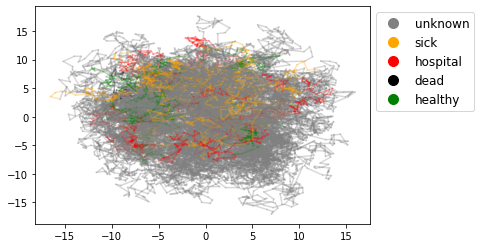

In [3]:
model.sim.plot_sim(sim)

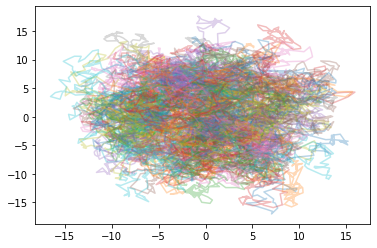

In [4]:
model.sim.plot_sim(sim, color_status=False)

In [5]:
sim['location'].head()

,patient,date,latitude,longitude
0,0,0,-2.245146,0.813738
1,0,1,-2.764336,-0.255947
2,0,2,-1.897354,-2.537493
3,0,3,-0.166531,-3.281504
4,0,4,0.148281,-3.515523


In [6]:
sim['tests'].head()

,patient,date,result
0,3,39,True
1,189,18,True
2,101,44,False
3,53,60,True
4,192,77,False


In [7]:
sim['hospital'].head()

,patient,date
0,180,41
5,198,24
7,109,36
10,64,12
11,65,17


In [8]:
sim['deaths'].head()

,patient,date
11,65,27
15,115,89
47,3,56


## Disease spread modeling

For model specification, see the [README](../../README.md)

In [6]:
# compute the average number of contacts per person per day
N_c = model.model.calculate_Nc(sim, distance_cutoff=1.5)
N_c

3.1087

In [7]:
# set the initial state -- at present everyone is healthy
state = model.model.initial_state(sim)
state

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

In [8]:
# evaluate contacts each day and update the model
for date in sim["dates"]["date"]:
    state = model.model.next_state(sim, state, date, N_c)

In [9]:
# print the final model state
with np.printoptions(threshold=np.inf):
    print(state.round(3))

[[0.    0.    0.    0.    0.    0.    0.002 0.978 0.02 ]
 [0.131 0.018 0.004 0.001 0.005 0.    0.002 0.83  0.01 ]
 [0.    0.    0.    0.    0.    0.    0.002 0.978 0.02 ]
 [0.    0.    0.    0.    0.    0.    0.287 0.57  0.143]
 [0.113 0.006 0.005 0.    0.008 0.001 0.003 0.854 0.01 ]
 [0.3   0.003 0.001 0.    0.001 0.    0.001 0.685 0.008]
 [0.865 0.03  0.002 0.001 0.003 0.    0.001 0.097 0.001]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.113 0.001 0.002 0.    0.003 0.    0.002 0.868 0.01 ]
 [0.211 0.022 0.009 0.003 0.012 0.001 0.003 0.731 0.008]
 [0.    0.    0.    0.    0.    0.    0.    0.98  0.02 ]
 [0.105 0.023 0.006 0.001 0.009 0.001 0.002 0.843 0.01 ]
 [0.083 0.044 0.006 0.001 0.008 0.001 0.003 0.844 0.01 ]
 [0.    0.    0.    0.    0.    0.    0.104 0.717 0.179]
 [0.091 0.004 0.002 0.    0.003 0.    0.001 0.888 0.011]
 [0.584 0.004 0.002 0.    0.003 0.    0.001 0.401 0.005]
 [0.151 0.004 0.005 0.    0.007 0.001 0.003 0.818 0.009]
 [0.338 0.012 0.004 0.    0.006